# Block Slide 3
## OCP Description
Lets introduce an extra dimension. Now the block can slide in 2D. We will assume the block is on 4 cartwheels and can move freely without friction. Lets add linear drag in both directions with a coefficient of friction of 1.05. The block starts at (1,-2) with zero speed, should reach the mid position (0,2) with any given speed, and final position (-1,-2) with zero speed, while dodging an circular object with a radius of 1[m] at (0,0) while minimizing input force.

In [30]:
# 2D Blockslide
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import pycollo

# State variables
x = sym.Symbol("x")  # Position (m) of the point horizontally from the origi(x-axis)
dx = sym.Symbol("dx")  # Velocity (m/s) of the point horizontally (x-axis)
# Control variables
y = sym.Symbol("y")  # Position (m) of the point horizontally from the origi(x-axis)
dy = sym.Symbol("dy")  # Velocity (m/s) of the point horizontally (x-axis)
# Control variables
Fx = sym.Symbol("Fx")  # Force (N) applied to the point horizontally (x-axis)
Fy = sym.Symbol("Fy")  # Force (N) applied to the point horizontally (x-axis)

r = 1.0
b = 1.05

# Static parameter variable
m = sym.Symbol("m")  # Mass (kg) of the point

# Problem instantiation
problem = pycollo.OptimalControlProblem(
    name="2D Block Slide",
    parameter_variables= (m)
    )
problem.bounds.parameter_variables = [[1,2]]
problem.guess.parameter_variables = [1.5]

phase_A = problem.new_phase(name="A")
phase_A.bounds.initial_time = 0
phase_A.bounds.final_time = [0, 10]
phase_A.guess.time = [0, 1]

## States and Control
State bounds, control, and integrand functions will be the same as the previous example but with an added dimension. 

In [31]:

phase_A.state_variables = [x, y, dx, dy]
phase_A.bounds.state_variables = [[-3,3],[-50,50]]
phase_A.bounds.state_variables = {
    x: [-3, 3],
    y: [-3, 3],
    dx: [-50, 50],
    dy: [-50, 50],}

phase_A.control_variables = [Fx, Fy]
phase_A.bounds.control_variables = {
    Fx: [-50, 50], 
    Fy: [-50,50]}
phase_A.guess.control_variables = [
        [0, 0],[0, 0]]

phase_A.integrand_functions = [Fx ** 2, Fy**2 ]
phase_A.bounds.integral_variables = [[0, 1000],[0,1000]]
phase_A.guess.integral_variables = [[0],[0]]

We will split the two phases by the two points the block should reach. The first phase will stop at the midpoint. Final state of dx and dy should be unconstrained and are set at the same limit as the statebounds. 

In [32]:
phase_A.bounds.initial_state_constraints = {
    x: 1,
    y: -2,
    dx: 0,
    dy: 0,}
phase_A.bounds.final_state_constraints = {
    x: 0,
    y: 2,
    dx: [-50, 50],
    dy: [-50, 50], }
phase_A.guess.state_variables = [[1, 0], [-2, 2], [0,0], [0,0]]

The state equations will be the same with an extra dimension and linear drag added to the equation.

In [33]:
phase_A.state_equations = {
    x: dx,
    y: dy,
    dx: Fx / m - b/m *dx,
    dy: Fy / m - b/m *dy}

## Path Constraints
Path constraints or inequality constraints, are constraints made up of continious time variables in contradiction with endpoint constraints. Path constraints are relatively hard to solve for the optimizer and should not be used when not necessary. 

The circular object with radius 1[m] located at (0,0) can be made with an inequality constraint. With the circle equation we can make sure x and y will be out of the circle at any time within phase A with a maximum of 10[m] distance. 

In [34]:
phase_A.path_constraints = [sym.sqrt(x ** 2 + y ** 2) - r]
phase_A.bounds.path_constraints = [[0, 10]]

## New phase
Now we can copy the previous phase completely to initiate a new phase completely the same. 

In [35]:
phase_B = problem.new_phase_like(
    phase_for_copying=phase_A,
    name="B",)

Now we overwrite everything that will be different from the last phase

- Time 
    Phase B initial time can start any moment within bounds, final time the same
- Initial and final state constraints
    The initial condition of phase B should be the same as the final state as phase A. The final location and speeds are implemented as described in the OCP

In [36]:
# Time 
phase_B.bounds.initial_time = [0, 10]
phase_B.bounds.final_time = [0, 10]
phase_B.guess.time = [1, 2]

# Initial and final state constraints
phase_B.bounds.initial_state_constraints = phase_A.bounds.final_state_constraints

phase_B.bounds.final_state_constraints = {
    x: -1,
    y: -2,
    dx: 0,
    dy: 0,}

## Endpoint constraints
To make sure all variables are continious, sometimes endpoint constraints need to be implemented. Endpoint constraints are constraintes which exist of initial and final variables. When final and initial states are not bound to a single value, phase A final states should match phase B initial states to make the states continious. Time variables are not constrained to be continious (yet), thus we can implement the following inequality constraint (final time phase A = initial time phase B -> final time phase A - initial time phase B = 0). In this example, x and y are constrainted to be continious due to the initial and final state constraints of both phases. The only constraint we'd like to implement to dx and dy is that the endpoints are corresponding and thus continious. This is done similarly as time.

In [37]:
problem.endpoint_constraints = [
    phase_A.final_time_variable - phase_B.initial_time_variable,
    phase_A.final_state_variables.dx - phase_B.initial_state_variables.dx,
    phase_A.final_state_variables.dy - phase_B.initial_state_variables.dy,]
problem.bounds.endpoint_constraints = [
    0,
    0,
    0,]

## Objective function 
Minimizing input forces is realised with the integrated functions of phase A and phase B

In [43]:
problem.objective_function = (
    phase_A.integral_variables[0] +phase_A.integral_variables[1] + phase_B.integral_variables[0] + phase_B.integral_variables[1])
# Bug
phase_B.guess.integral_variables = [[0],[0]]

In [ ]:
## Settings
To converge quicker in this relatively simple OCP, lets reduce the NLP tolerance and mesh tolerance. And lets add more collocations points by increasing the number of mesh sections to account for the lower tolerances.

In [40]:
problem.settings.display_mesh_result_graph = True
problem.settings.nlp_tolerance  = 1e-8
problem.settings.mesh_tolerance = 1e-6

phase_A.mesh.number_mesh_sections = 30
phase_B.mesh.number_mesh_sections = 30

## Solve and Plot


Initialising optimal control problem.

Phase variables and equations checked.
Pycollo variables and constraints preprocessed.
Backend initialised.
Bounds checked.
Problem scaling initialised.
Quadrature scheme initialised.
Backend postprocessing complete.
Initial mesh created.
Initial guess checked.

Initialising mesh iteration #1.

Guess interpolated to iteration mesh in 1.46ms.
Scaling initialised in 108.67us.
Initial guess scaled in 10.62us.
Scaling generated in 97.59ms.
NLP generated in 740.12ms.
Mesh-specific bounds generated in 802.12us.

Mesh iteration #1 initialised in 840.10ms.


Solving mesh iteration #1.

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     6820
Number of nonzeros in inequality constraint Jacobian.:      356
Number of nonzeros in Lagrangian Hessian.............:     2712

Total number of variables............................:     1088
                     variables with only lower

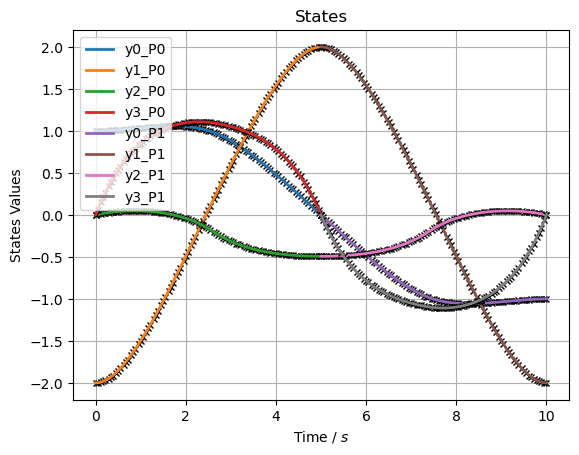

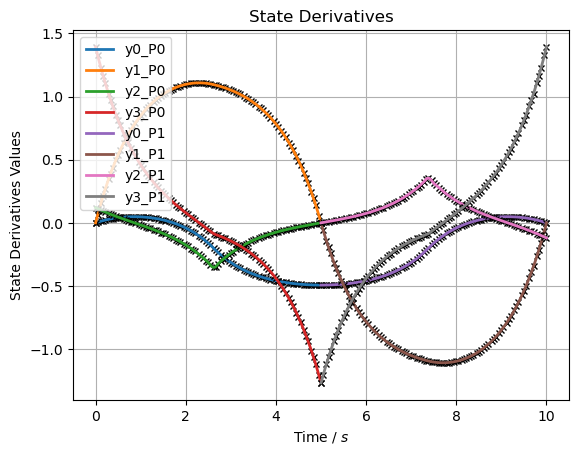

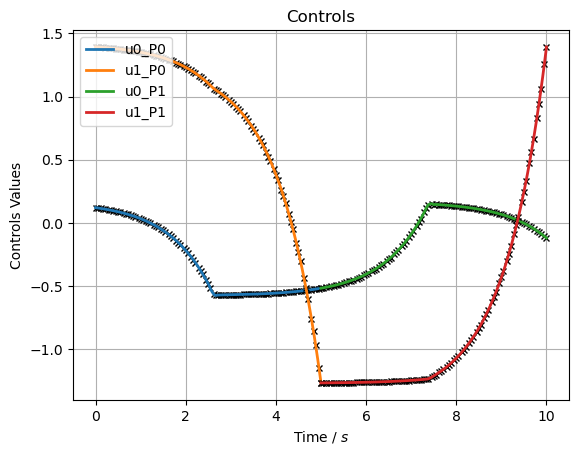

Mesh tolerance met in mesh iteration 1.


Optimal control problem sucessfully solved.

Final Objective Function Evaluation: 12.5274



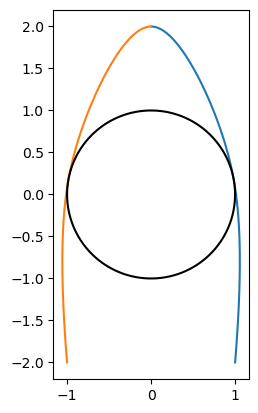

In [41]:
problem.initialise()
problem.solve()

## Plot
# Create obstacle coordinates
alpha = np.linspace(0, 2 * np.pi, 1000)
x_circle = r * np.cos(alpha)
y_circle = r * np.sin(alpha)

# Plot obstacle and solution in plan view
x_P0 = problem.solution.state[0][0]
y_P0 = problem.solution.state[0][1]
x_P1 = problem.solution.state[1][0]
y_P1 = problem.solution.state[1][1]
plt.plot(x_P0, y_P0)
plt.plot(x_P1, y_P1)
plt.plot(x_circle, y_circle, color="#000000")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

### Solution
All results can be found in problem.solution, see [INSERT_LINK_TO_SOLUTION]